In [1]:
# ES control minimizing a quadratic function
# Dan Arnold, daniel.brian.arnold@gmail.com

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#ES function
#gets called every timestep

def es_function(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, akm1, lpf_a):
    
    #outputs:
    #uk: the control to be applied at the next timestep
    #uhatk: the output of the integrator
    #gammak: the output of the lowpass filter
    #psik: signal after demodulation (mutliplication by cosine)
    #sigmak: the output of the washout (highpass) filter
    
    #inputs:
    #Jk, Jkm1: values of the objective function (metric we're optimizing) at the present and last timestep
    #sigmakm1: output of highpass filter at last timestep
    #psikm1: signal after demodulation at last timestep
    #gammakm1: output of lowpass filter 
    #uhatkm1: output of integrator at last timestep
    #t: present time at this timestep
    #T: distance between timesteps, delta_T
    #hpf: high pass filter gain, usually make this an order of magnitude lower than w
    #lpf: low pass filter gain, usually make this equal to hpf, but I usually end up adjusting this quite a bit
    #c: gain on the integrator - how much to value new measurements compared to old measurements
    #ak: the amplitude of the probing signal

    #calculate angular frequency:
    w = 2*np.pi*f

    #extract the effect of the probing signal in the objective function
    #do this by passing the signal through a highpass filter
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)

    #the resulting signal is a sinusoid, multiply by a sinusoid of the same frequency
    #this results in a cos**2 term, that has a DC component (we call this demodulation)
    psik = sigmak*np.cos(w*t)

    #pass the demodulated signal through a lowpass filter, to eliminate noise and "jumpiness"
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)
    
    #probe amplitude adaptation
    ak = a_param * (T*lpf_a*( (np.arctan(psik) / np.pi * 2 )**2 + (np.arctan(psikm1) / np.pi * 2)**2)) - (T*lpf_a - 2)*akm1/(2 + T*lpf_a)

    #pass the resulting signal through an integrator - this approximates a gradient descent
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    #modulation - add the perturbation to the next control setpoint
    uk = (uhatk + ak*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk, ak)

program running
program complete, number of iterations: 6701


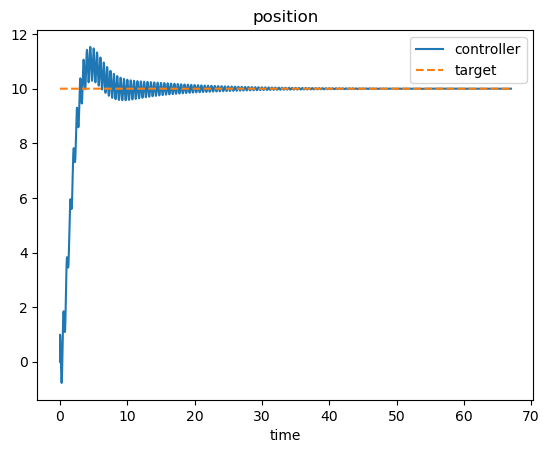

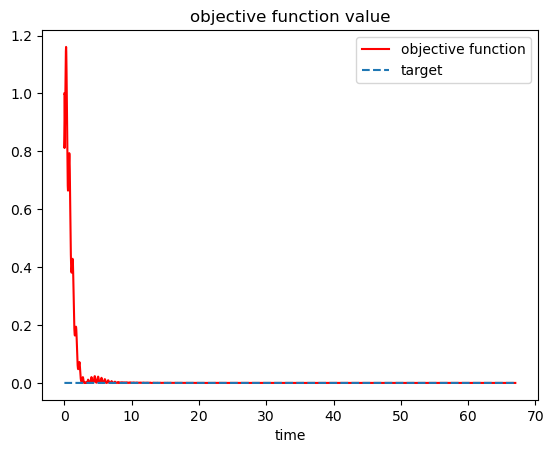

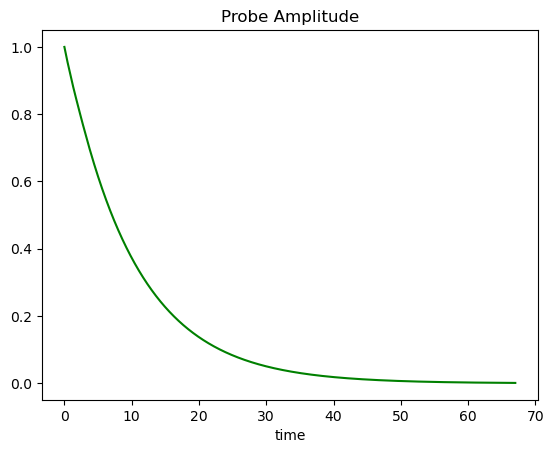

In [3]:
#Simulation

#Line search - the goal of this experiment is to minimize a quadratic function
#the initial value of the controller, u, is the starting position
#we want to drive this value to the minimum of the quadratic, or u=0

#setup time
T = 0.01 #delta T: the length of each timestep
time = []
time.append(0)

#setup vectors to store past values of the ES control
J = [] #objective function
sigma = [] #value after highpass (washout) filter
psi = [] #value after demodulation
gamma = [] #value after lowpass filter
uhat = [] #value after integration
u = []  #control outputs of ES control (position)
a = [] #probing amplitude

#initial conditions
u0 = 0 #initial location
u.append(u0) #choosing an initial condition - in this case its a position at these many units away from the origin
u_target = 10
J.append( (((u[0] - u_target) / u_target)**2)/1 )
sigma.append(u[0])
psi.append(u[0])
gamma.append(u[0])
uhat.append(u[0])
a0 = 1 #amplitude of the probe
a.append(a0)

#setup parameters for the ES controller
f = 2 #frequency of probe, in Hz
c = -100 #gain on the integrator
lpf = 1 #lowpass filter critical frequency
hpf = 1 #highpass filter critical frequency
lpf_a = 0.1

delta = 100
epsilon = 1e-5

print("program running")
i = 0
while(delta >= epsilon):
    
    #don't do anything the first timestep
    if(i>=1):

        #evaluate objective function value
        #minimize a quadratic, minimum value is 0
        J.append( (((u[i-1] - u_target) / u_target)**2 )/1 )
        
        #call the ES controller
        uk, sigmak, psik, gammak, uhatk, ak = es_function(time[i], T, hpf, lpf, f, c, a0, J[i], J[i-1], \
            sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1], a[i-1], lpf_a)

        #store values for next timestep
        u.append(uk)
        sigma.append(sigmak)
        psi.append(psik)
        gamma.append(gammak)
        uhat.append(uhatk)
        a.append(ak)
        #print("----------------------------")
    
        delta = np.abs(u[i] - u[i-1]) + np.abs(a[i] - a[i-1])
    
    time.append(time[i] + T)
    i+=1

print("program complete, number of iterations:", i)
time.pop() #remove last element from time vector

#Plot Results
target = np.ones(len(u))*u_target;

#this is the output of the ES controller
fig1 = plt.figure(1)
plt.plot(time,u,label="controller")
plt.plot(time,target,'--',label="target")
plt.title('position')
plt.xlabel('time')
plt.legend()
fig1.savefig('ES_basic.png')

plt.figure(2)
plt.plot(time,J,'r',label="objective function")
plt.title('objective function value')
plt.plot(time,np.zeros(len(u)),'--',label="target")
plt.xlabel('time')
plt.legend()

plt.figure(3)
plt.plot(time,a,'g')
plt.xlabel('time')
plt.title('Probe Amplitude')

plt.show()